<a href="https://colab.research.google.com/github/emmanuelmokel/PPL-practice/blob/main/TFP_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow -y -q
!pip install -Uq tfp-nightly[jax] > /dev/null

In [2]:
# Importing basic packages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
sns.set(style = 'white')

In [3]:
# Importing packages for TFP and JAX
import jax.numpy as jnp
from jax import grad
from jax import jit
from jax import random
from jax import value_and_grad
from jax import vmap
from tensorflow_probability.substrates import jax as tfp

# Setting modules as variables?
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [4]:
iris = datasets.load_iris()
features, labels = iris['data'], iris['target']

num_features = features.shape[-1]
num_classes = len(iris.target_names)

In [5]:
Root = tfd.JointDistributionCoroutine.Root
def model():
  w = yield Root(tfd.Sample(tfd.Normal(0., 1.), sample_shape =(num_features,
                                                               num_classes)))
  b = yield Root(tfd.Sample(tfd.Normal(0., 1.), sample_shape = (num_classes,)))
  logits = jnp.dot(features, w) + b
  yield tfd.Independent(tfd.Categorical(logits = logits),
                        reinterpreted_batch_ndims = 1)

dist = tfd.JointDistributionCoroutine(model)
def target_log_prob(*params):
  return dist.log_prob(params + (labels,))

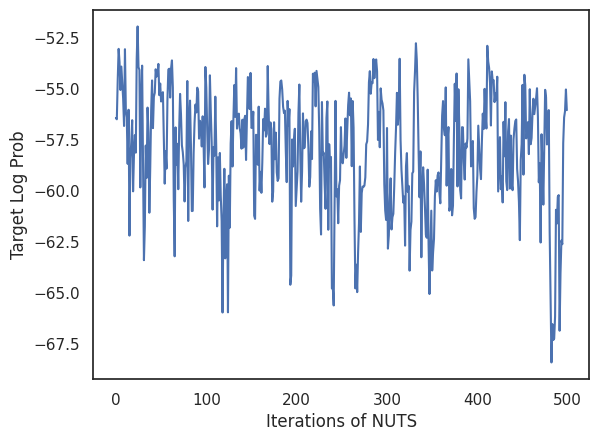

17.283952236175537


In [6]:
import time
init_key, sample_key = random.split(random.PRNGKey(0))
init_params = tuple(dist.sample(seed = init_key)[:-1])

@jit
def run_chain(key, state):
  kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
  return tfp.mcmc.sample_chain(500, current_state = state, kernel = kernel,
                               trace_fn = lambda _, results:
                               results.target_log_prob,
                               num_burnin_steps = 500, seed = key)
start = time.time()
states, log_probs = run_chain(sample_key, init_params)
end = time.time()
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of NUTS')
plt.show()

print(end-start)

In [7]:
def classifier_probs(params):
  dists, _ = dist.sample_distributions(seed=random.PRNGKey(0),
                                       value=params + (None,))
  return dists[-1].distribution.probs_parameter()

all_probs = jit(vmap(classifier_probs))(states)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1)== labels))

Average accuracy: 0.96812
BMA accuracy: 0.9866667


In [9]:
dist = tfd.Normal(0., 1.)
print(dist.log_prob(0.))
dist.sample(seed = random.PRNGKey(0))

-0.9189385


Array(-0.20584226, dtype=float32)

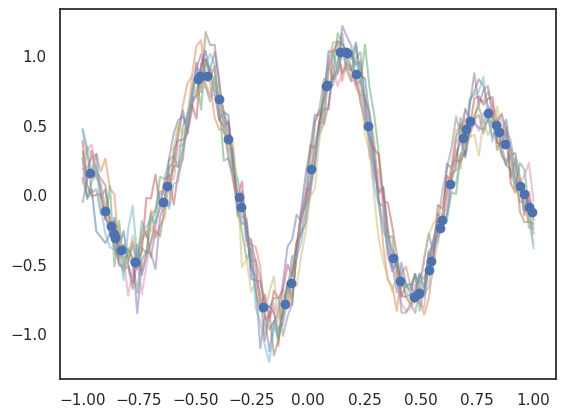

In [14]:
# Gaussian Process Model

k1, k2, k3 = random.split(random.PRNGKey(0), 3)
obs_var = 0.01
f = lambda x: jnp.sin(10*x[..., 0])*jnp.exp(-x[...,0]**2)
obs_index_pts = random.uniform(k1, [50], minval = -1., maxval = 1.)[..., jnp.newaxis]
obs = f(obs_index_pts) + tfd.Normal(loc = 0., scale = jnp.sqrt(obs_var)).sample(seed = k2)

index_pts = jnp.linspace(-1., 1., 100)[..., jnp.newaxis]

kernel = tfpk.ExponentiatedQuadratic(length_scale = 0.1)

gprm = tfd.GaussianProcessRegressionModel(
    kernel = kernel,
    index_points = index_pts,
    observation_index_points = obs_index_pts,
    observations = obs,
    observation_noise_variance = obs_var
)

samples = gprm.sample(10, seed = k3)
for i in range(10):
  plt.plot(index_pts, samples[i], alpha = 0.5)
plt.plot(obs_index_pts, obs, marker = 'o', linestyle = '')
plt.show()

In [15]:
initial_distribution = tfd.Categorical(probs=[0.8, 0.2])
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])

observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])

model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

print(model.mean())
print(model.log_prob(jnp.zeros(7)))
print(model.sample(seed=random.PRNGKey(0)))

[2.9999998 5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ]
-19.855635
[ 1.3641367  0.505798   1.3626463  3.6541772  2.272286  15.10309
 22.794212 ]
